# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 9.0 (все обязательное вроде выполнила! Кроме одного из отборов на балл  )

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [298]:
 #!pip install --upgrade scikit-learn


In [2]:
import sklearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [6]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [7]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [8]:
def plot_curves(test_y, pred_y, model_name):

    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    PrecisionRecallDisplay.from_predictions(test_y, pred_y, ax=ax[0])
    precision, recall, _ = precision_recall_curve(test_y, pred_y)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC for " + model_name)
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(test_y, pred_y, ax=ax[1])
    print('AUC-ROC: %.5f' % roc_auc_score(test_y, pred_y))
    ax[1].set_title("ROC for " + model_name)
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    return  "ROC_AUC: {0:.5f}".format(roc_auc_score(test_y, pred_y)), "ROC_PR: {0:.5f}".format(auc(recall, precision))

AUC-PR: 0.63340
AUC-ROC: 0.50394


('ROC_AUC: 0.50394', 'ROC_PR: 0.63340')

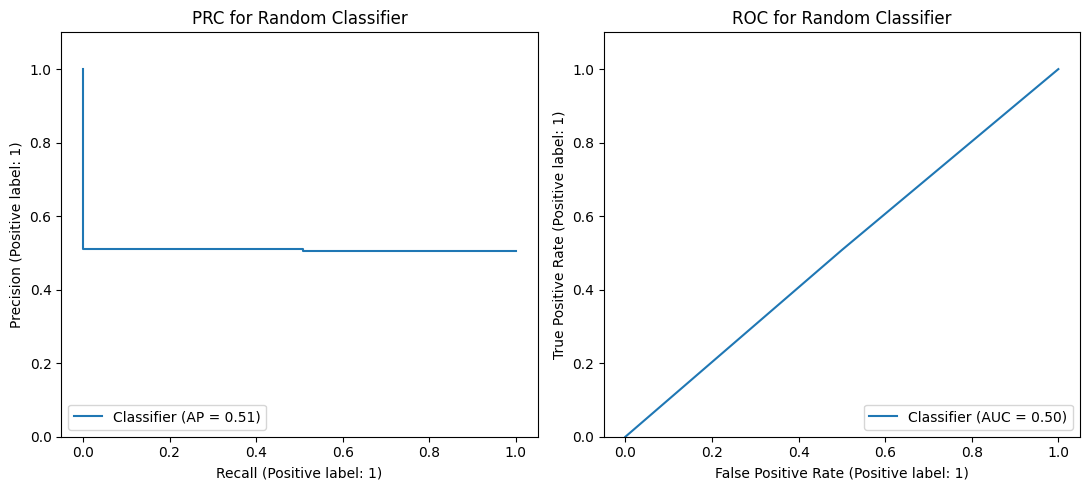

In [9]:
plot_curves(y_test, y_random, 'Random Classifier')

In [18]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
def add_metrics(classifier_name, test_y, pred_y, intercept= None):

    precision, recall, _ = precision_recall_curve(test_y, pred_y)
    df_metrics.loc[classifier_name] = [
        auc(recall, precision),
        roc_auc_score(test_y, pred_y),
        intercept
    ]
    return df_metrics


In [19]:
add_metrics('Radom_classifier', y_test, y_random)


,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [20]:
### SVM without CV
from sklearn.svm import SVC

clf = SVC(kernel='linear', gamma='auto', C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
add_metrics('SVС_no_CV', y_test, y_pred, clf.intercept_)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]


In [21]:
# AUC PR scorer
from sklearn.metrics import make_scorer

def AUC_PR_Loss(test_y, pred_y):
    precision, recall, _ = precision_recall_curve(test_y, pred_y)
    return auc(recall, precision)

scorer = {'custom': make_scorer(AUC_PR_Loss, greater_is_better=True)}


In [22]:
### SVM CV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
best_params = pd.DataFrame(columns = ['best_params'])

def cross_val_custom (estim, params, model_name, train_x, train_y, test_x, test_y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    mdl = GridSearchCV(estimator=estim,
    scoring = scorer, cv = cv, param_grid=params,
    refit='custom')

    mdl.fit(train_x, train_y)
    try:
        inter = clf.intercept_
    except: 
        inter = None
    
    pred = mdl.predict(test_x)
    add_metrics(model_name, test_y, pred, inter)

    plot_curves(test_y, pred, model_name)
    best_params.loc[model_name] = [mdl.best_estimator_]

    return mdl.best_estimator_



AUC-PR: 0.83236
AUC-ROC: 0.77322


SVC(C=0.01, gamma='auto', kernel='linear')

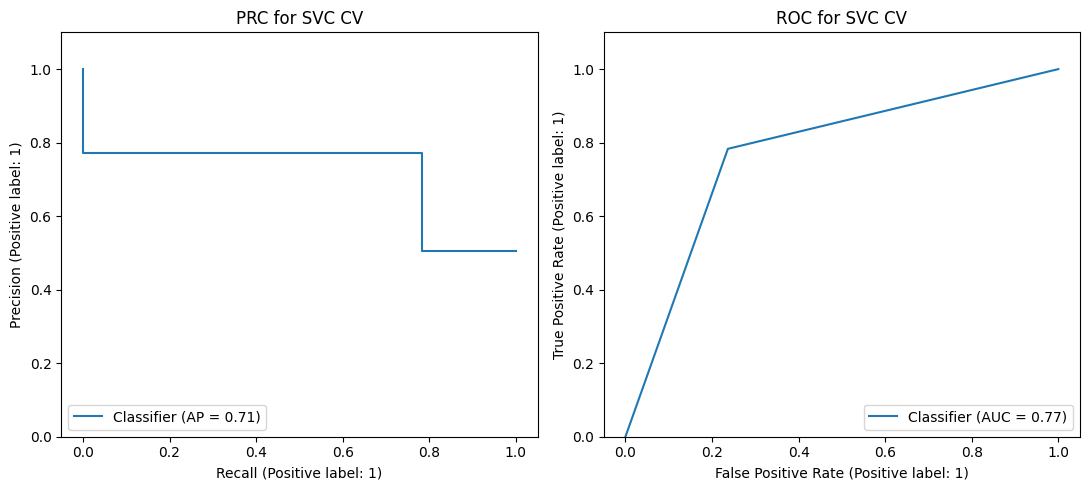

In [23]:
params = {'C': [1e-3, 0.01, 0.1, 1, 10]}
cross_val_custom(SVC(kernel='linear', gamma='auto'), params, 'SVC CV', X_train, y_train, X_test, y_test)


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Все выше

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [24]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]


Радует то, что они значительно выше. Но вообще говоря, не линейное ядро перформило сильно лучше

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [26]:
### Linreg without CV
from sklearn import linear_model

ridge_no_cv = linear_model.LogisticRegression(penalty='l2', C=1)

ridge_no_cv.fit(X_train, y_train)

ridge_no_cv_pred = ridge_no_cv.predict(X_test)
add_metrics('Ridge_no_CV', y_test, ridge_no_cv_pred, ridge_no_cv.intercept_)


,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]


AUC-PR: 0.83207
AUC-ROC: 0.77240


LogisticRegression(C=0.1, max_iter=1000)

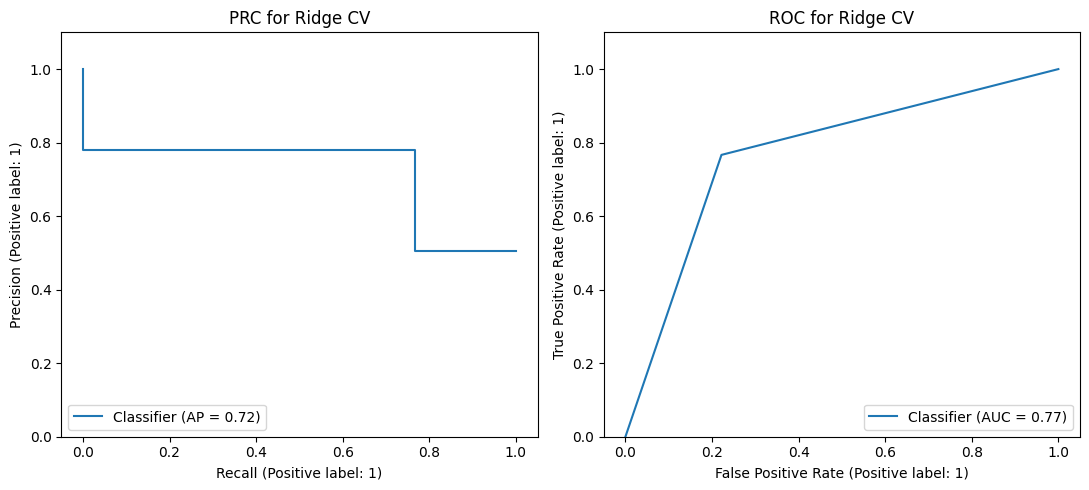

In [27]:
### Linreg CV
params = {'C': [0.001, 0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter=1000), params, 'Ridge CV', X_train, y_train, X_test, y_test)


In [28]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: во-первых, отмечу, что без кросс-валидации скор выше. Вроде как это нормально, нужно доверяться скору CV, он точнее

  Во-вторых, ну разница незначительная (только после 4 знака после запятой), но SVM лучше. Мне кажется, идейно здесь нет какой-то интепретации. Минимизация Margin для этих данных эффективней

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [29]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
model = SVC(kernel='linear', C=0.1, gamma = 'auto')
model.fit(X_train, y_train)

SVC(C=0.1, gamma='auto', kernel='linear')

Идея отсюда: https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92 


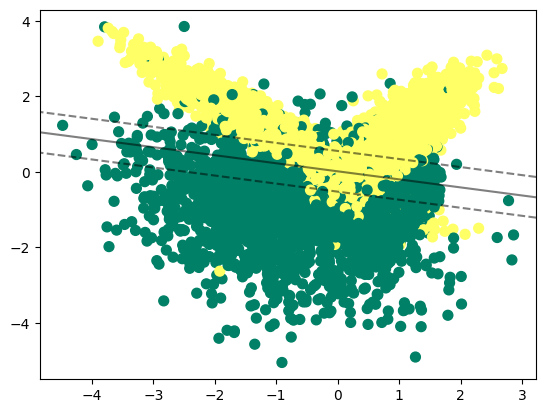

In [31]:
ax = plt.gca()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='summer')
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

x_lim_10 = np.linspace(x_lim[0], x_lim[1], 10)
y_lim_10 = np.linspace(y_lim[0], y_lim[1], 10)
YY, XX = np.meshgrid(y_lim_10, x_lim_10)

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [32]:
logreg = linear_model.LogisticRegression(penalty='l2', C=1)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict_proba(X_train)

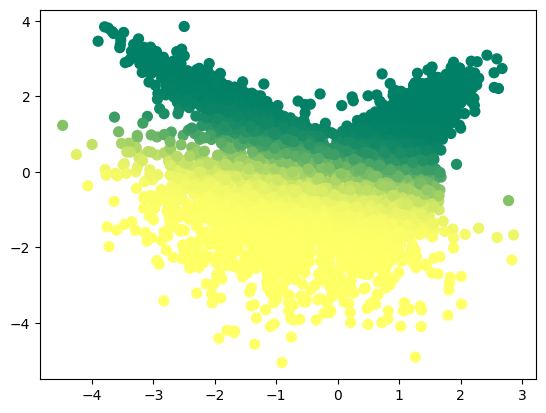

In [33]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred_train[:, 0], s=50, cmap='summer')

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [34]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    l = 0

    for i in range(n_bins):
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1)/ np.sum([(preds >= l) & (preds < r)]) )
        l = r
    #print(bin_real_ratios)
    plt.figure(figsize=(6,6))
    #print(bin_middle_points)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

In [35]:
best_params

,best_params
SVC CV,"SVC(C=0.01, gamma='auto', kernel='linear')"
Ridge CV,"LogisticRegression(C=0.1, max_iter=1000)"


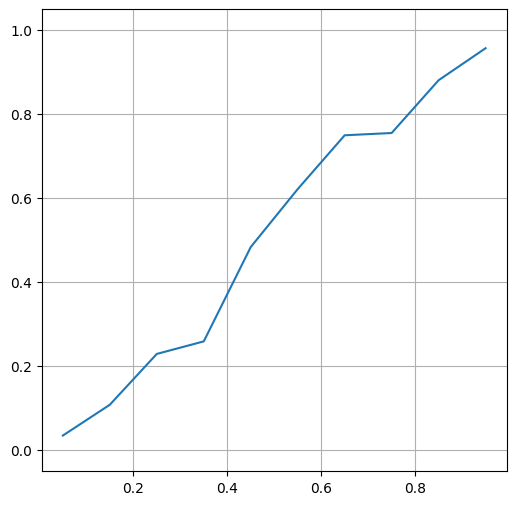

In [36]:
svc = SVC(C=1, gamma='auto', kernel='linear', probability=True)
svc.fit(X_train, y_train)
predicts_svc = svc.predict_proba(X_test)
plot_calibration_curve(y_test, predicts_svc[:,1])


(array([2087.,  589.,  333.,  290.,  218.,  238.,  243.,  333.,  537.,
        2132.]),
 array([5.36495466e-07, 1.00000482e-01, 2.00000427e-01, 3.00000373e-01,
        4.00000318e-01, 5.00000264e-01, 6.00000209e-01, 7.00000155e-01,
        8.00000100e-01, 9.00000046e-01, 9.99999991e-01]),
 <BarContainer object of 10 artists>)

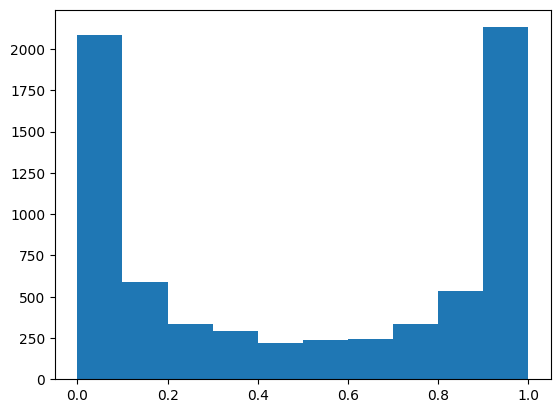

In [37]:
y_pred_train = svc.predict_proba(X_train)
plt.hist(y_pred_train[:,1])

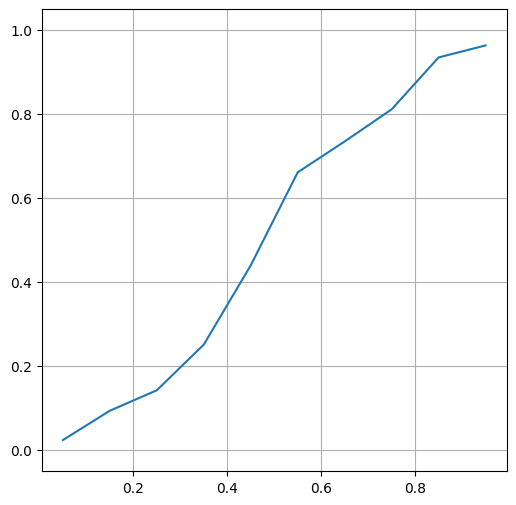

In [38]:
logreg = linear_model.LogisticRegression(C=0.01)
logreg.fit(X_train, y_train)
predicts_lgr = logreg.predict_proba(X_test)
plot_calibration_curve(y_test, predicts_lgr[:,1])



(array([1601.,  764.,  469.,  386.,  289.,  299.,  344.,  456.,  716.,
        1676.]),
 array([1.59660617e-05, 9.99615905e-02, 1.99907215e-01, 2.99852839e-01,
        3.99798464e-01, 4.99744088e-01, 5.99689712e-01, 6.99635337e-01,
        7.99580961e-01, 8.99526586e-01, 9.99472210e-01]),
 <BarContainer object of 10 artists>)

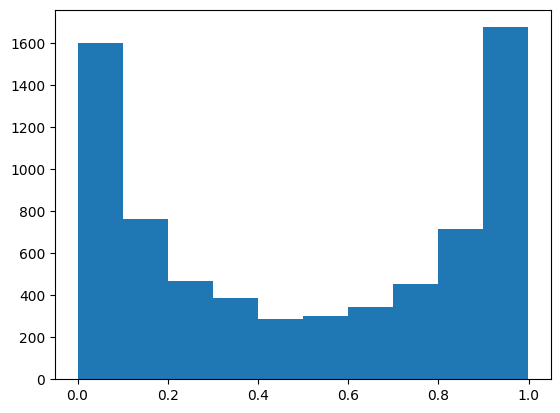

In [39]:
y_pred_train = logreg.predict_proba(X_train)
plt.hist(y_pred_train[:,1])


Чем они различаются? Чем вы можете объяснить это?

Ответ: Оч похожи, но как будто логрег плавнее. SVM бОльшую долю 1 выдает на средних отрезках

SVM меньше объектов оставляет "в зоне неопределенности", близкой к 0.5

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [40]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=svc, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42))

In [41]:
calibrated_clf.fit(X_train, y_train)
probs_calibr = calibrated_clf.predict_proba(X_test)

In [42]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs_calibr[:,1])

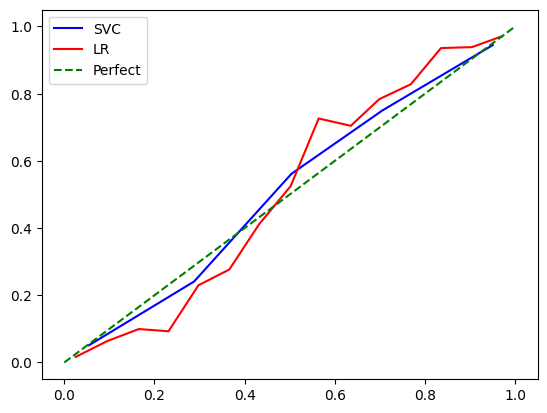

In [43]:

lr_true_prob, lr_pred_prob = calibration_curve(y_test, predicts_lgr[:,1], n_bins=15)

plt.plot(prob_pred, prob_true, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='red')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()
plt.show()



##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [44]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [45]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-26 17:10:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: 'adult.data.2'

adult.data.2        100%[===================>]   3.79M   198KB/s    in 15s     

2022-11-26 17:11:13 (255 KB/s) - 'adult.data.2' saved [3974305/3974305]



In [46]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [47]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

Ну тут сразу надо кикнуть `education-num` тк это уже кодировка для образования

In [48]:
#df = df.drop(columns = ['education-num', 'relationship'])
#df

In [49]:
X = df.drop(['income'], axis = 1)
y = df['income']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [51]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

column_transformer = ColumnTransformer([
    ('orenc', OrdinalEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [52]:
X = df.drop(['income'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

AUC-PR: 0.63991
AUC-ROC: 0.69174


LogisticRegression(C=10, max_iter=1000)

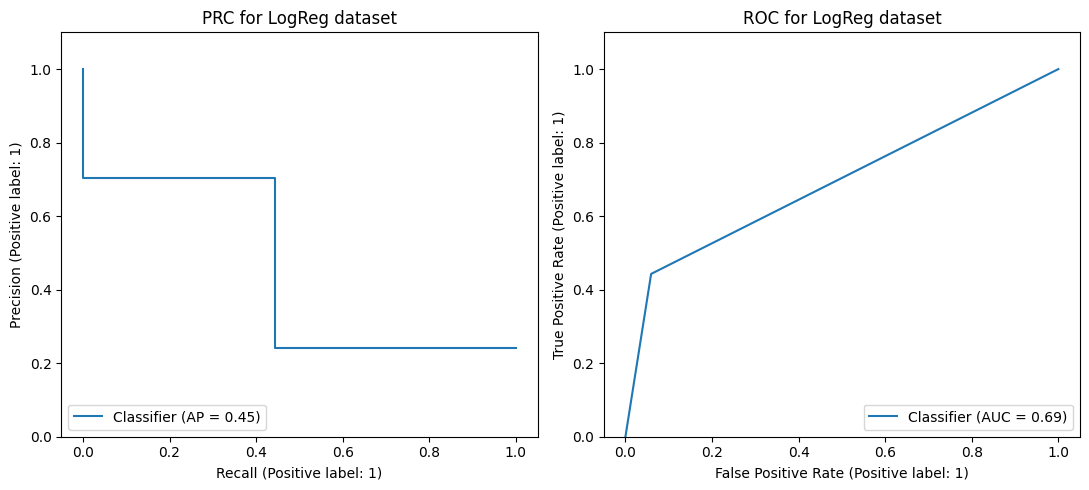

In [53]:
params = {'C': [0.001, 0.01, 0.1, 1, 10]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter=1000), params, 'LogReg dataset', X_train, y_train, X_test, y_test)

In [54]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]
LogReg dataset,0.639914,0.691741,[0.0005306229632245509]


In [55]:
y.mean()

0.2408095574460244

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: Из-за дисбаланса классов, у нас всего 24% тех, у кого высокая зп. Более того, нам важно предсказать тех, у кого высокая зп, поэтому мы берем эту метрику, тк она более чувствительна к ошибкам в положительном классе 

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [56]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(['income'], axis = 1)
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

column_transformer_ohe = ColumnTransformer([
    ('orenc', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)
X_train = column_transformer_ohe.fit_transform(X_train)
X_test = column_transformer_ohe.transform(X_test)

X_train.shape

(24420, 108)

AUC-PR: 0.71885
AUC-ROC: 0.76666


LogisticRegression(C=1, max_iter=1000)

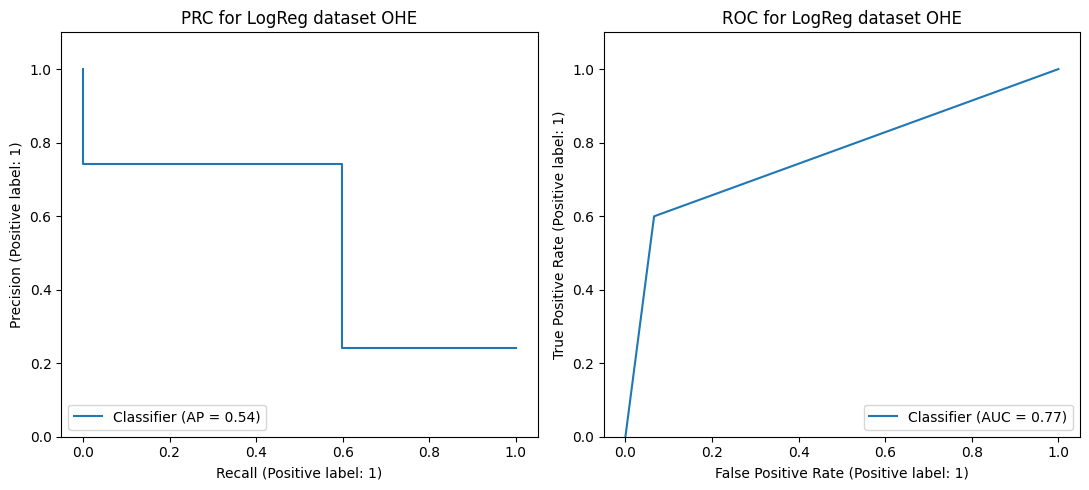

In [58]:
params = {'C': [0.001, 0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter = 1000), params, 'LogReg dataset OHE', X_train, y_train, X_test, y_test)

In [59]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]
LogReg dataset,0.639914,0.691741,[0.0005306229632245509]
LogReg dataset OHE,0.718854,0.766660,[0.0005306229632245509]


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [67]:
X = df.drop(['income'], axis = 1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)

In [68]:
def target_enc(X_train, X_test, noise = False, smoothing = False, C = 10):   
    df_train = df[~df.index.isin(X_test.index)]

    
    for feature in categorical_features:

        diff = np.setdiff1d(np.unique(X_test['native-country']),np.unique(df_train[feature]))
        if diff.size:
            for dif in diff:
                X_test.loc[X_test[feature] == dif, feature] = np.mean(df_train['income'])
        

        for typ in np.unique(df_train[feature]):

                X_test.loc[X_test[feature] == typ, feature] = np.mean(df_train.loc[df_train[feature] == typ, 'income']) + smoothing* C *np.mean(df_train['income'])
                df_train.loc[df_train[feature]== typ, feature] = np.mean(df_train.loc[df_train[feature] == typ, 'income']) +smoothing* C *np.mean(df_train['income'])

    X_train = df_train.drop(['income'], axis = 1)
    
    for col in categorical_features:
        X_test[col] = pd.to_numeric(X_test[col])
        X_train[col] = pd.to_numeric(X_train[col])
        
    if noise:
        for feature in categorical_features:
            noise = np.random.uniform(0, np.max(X_train[feature])/2, X_train.shape[0])
            X_train[feature]+= noise

            noise = np.random.uniform(0, np.max(X_test[feature])/2, X_test.shape[0])
            X_test[feature] += noise
        
    
    X_train = (X_train-X_train.mean(axis= 0))/X_train.std(axis = 0)
    X_test = (X_test-X_test.mean(axis= 0))/X_test.std(axis = 0)

    return X_train, X_test

In [69]:
X_train1, X_test1 = target_enc(X_train, X_test)

AUC-PR: 0.62038
AUC-ROC: 0.50000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


LogisticRegression(C=0.001, max_iter=1000)

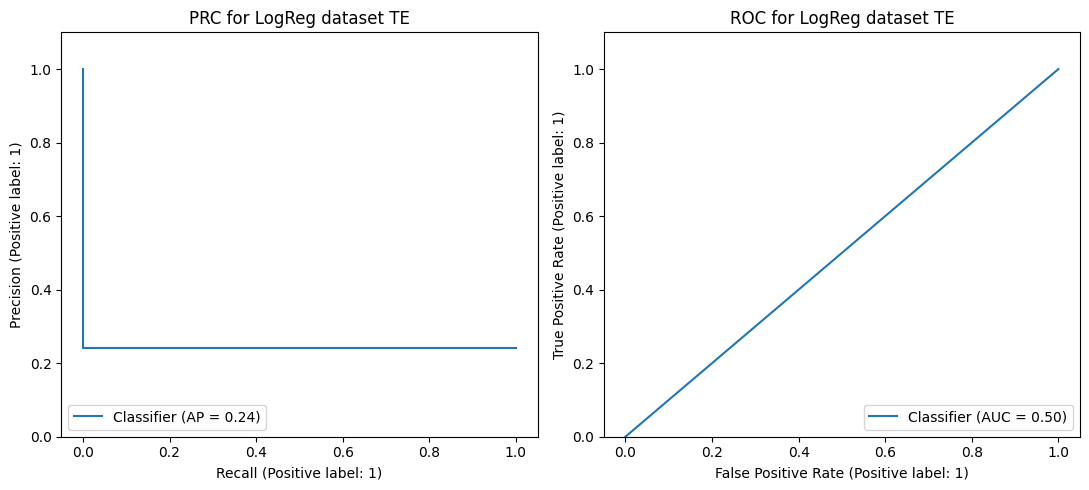

In [70]:
params = {'C': [0.001, 0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter=1000), params, 'LogReg dataset TE', X_train1, y_train, X_test1, y_test)

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  

In [72]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]
LogReg dataset,0.639914,0.691741,[0.0005306229632245509]
LogReg dataset OHE,0.718854,0.766660,[0.0005306229632245509]
LogReg dataset TE,0.620378,0.500000,[0.0005306229632245509]


In [73]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train1.values, i)
                          for i in range(len(X_train1.columns))]

In [74]:
vif_data

,feature,VIF
0,age,1.216215
1,workclass,1.110591
2,fnlwgt,1.029734
3,education,5.892605
4,education-num,5.809487
5,marital-status,17.248004
6,occupation,1.465484
7,relationship,17.537906
8,race,1.040192
9,sex,1.259667


очевидно, education и education - code коррелируют, как и marital status и relationship, но решила оставить мб добавят прогнозной силы в модель 

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [75]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [76]:
X_train2, X_test2 = target_enc(X_train, X_test, True, False, 10)

AUC-PR: 0.62038
AUC-ROC: 0.50000


LogisticRegression(C=0.001)

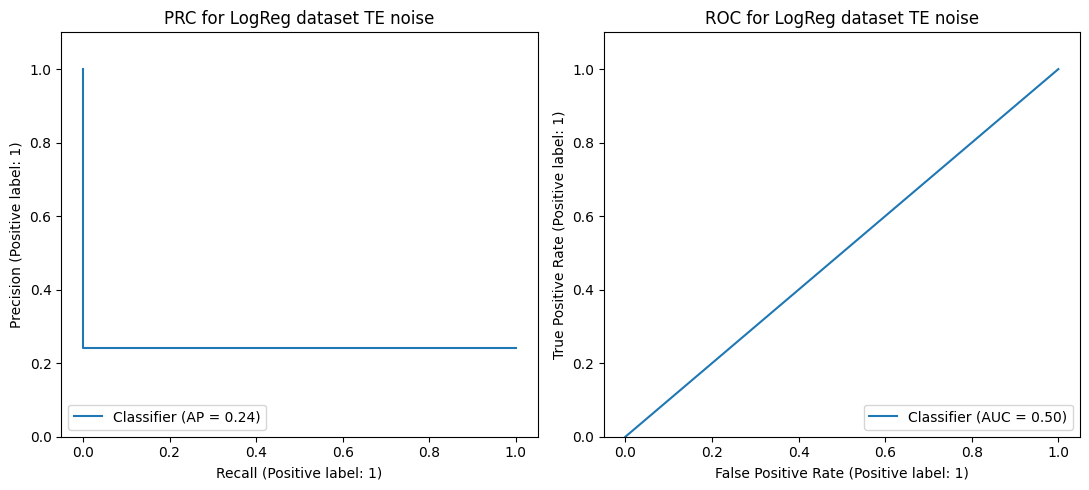

In [77]:
params = {'C': [0.001, 0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2'), params, 'LogReg dataset TE noise', X_train2, y_train, X_test2, y_test)

In [78]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]
LogReg dataset,0.639914,0.691741,[0.0005306229632245509]
LogReg dataset OHE,0.718854,0.766660,[0.0005306229632245509]
LogReg dataset TE,0.620378,0.500000,[0.0005306229632245509]
LogReg dataset TE noise,0.620378,0.500000,[0.0005306229632245509]


Не понимаю, почему метрика не улучшается!


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [79]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [80]:
X_train3, X_test3 = target_enc(X_train, X_test, True, True, 10)

AUC-PR: 0.62038
AUC-ROC: 0.50000


LogisticRegression(C=0.01, max_iter=1000)

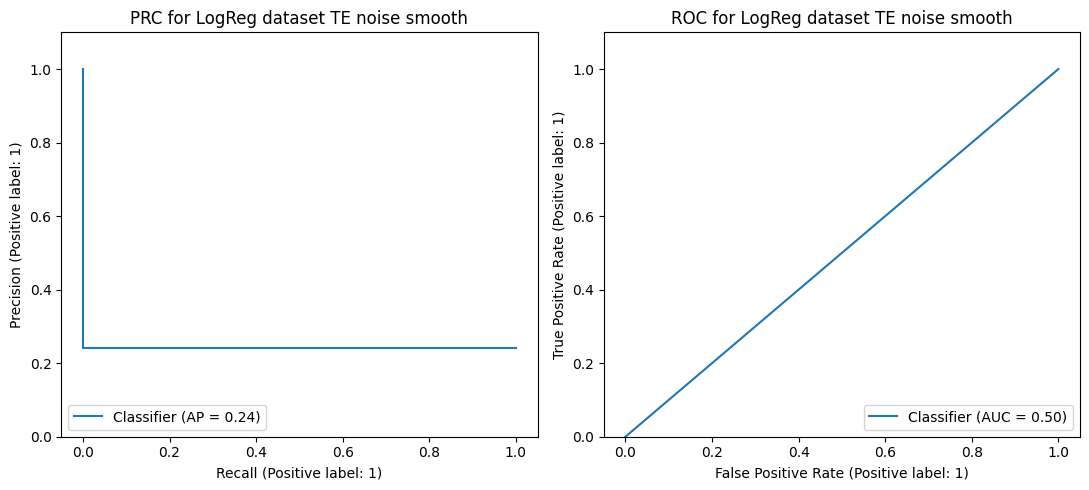

In [81]:
params = {'C': [0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter=1000), params, 'LogReg dataset TE noise smooth', X_train3, y_train, X_test3, y_test)

In [82]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Radom_classifier,0.633402,0.503944,NaN
SVС_no_CV,0.832571,0.773536,[0.0005306229632245509]
SVC CV,0.832361,0.773221,[0.0005306229632245509]
Ridge_no_CV,0.832566,0.773065,[-0.0472266688647607]
Ridge CV,0.832068,0.772399,[0.0005306229632245509]
LogReg dataset,0.639914,0.691741,[0.0005306229632245509]
LogReg dataset OHE,0.718854,0.766660,[0.0005306229632245509]
LogReg dataset TE,0.620378,0.500000,[0.0005306229632245509]
LogReg dataset TE noise,0.620378,0.500000,[0.0005306229632245509]
LogReg dataset TE noise smooth,0.620378,0.500000,[0.0005306229632245509]


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [85]:
#your code here

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [86]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [87]:
#df = df.drop('education-num', axis = 1)

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [88]:
X = df.drop('income', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [89]:
column_transformer_ohe = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [90]:
for col in ['age', 'hours-per-week']:
    X[col] = X[col].astype('object')

In [91]:
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

X_train = column_transformer_ohe.fit_transform(X_train)
X_test = column_transformer_ohe.transform(X_test)


In [92]:
X_train.shape

(24420, 108)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

AUC-PR: 0.71885
AUC-ROC: 0.76666


LogisticRegression(C=1, max_iter=1000)

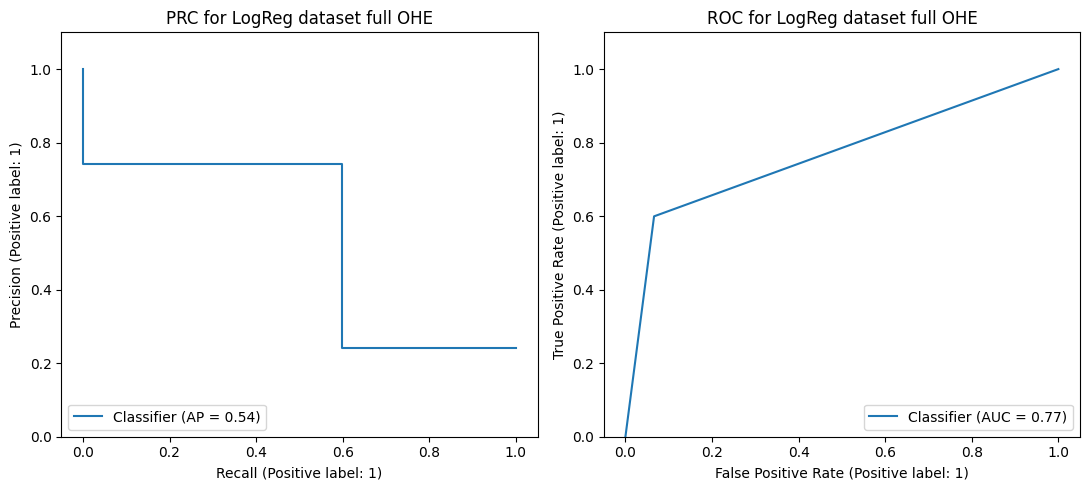

In [93]:
params = {'C': [0.001, 0.01, 0.1, 1]}
cross_val_custom(linear_model.LogisticRegression(penalty='l2', max_iter = 1000), params, 'LogReg dataset full OHE', X_train, y_train, X_test, y_test)

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [94]:
best_params

,best_params
SVC CV,"SVC(C=0.01, gamma='auto', kernel='linear')"
Ridge CV,"LogisticRegression(C=0.1, max_iter=1000)"
LogReg dataset,"LogisticRegression(C=10, max_iter=1000)"
LogReg dataset OHE,"LogisticRegression(C=1, max_iter=1000)"
LogReg dataset TE,"LogisticRegression(C=0.001, max_iter=1000)"
LogReg dataset TE noise,LogisticRegression(C=0.001)
LogReg dataset TE noise smooth,"LogisticRegression(C=0.01, max_iter=1000)"
LogReg dataset full OHE,"LogisticRegression(C=1, max_iter=1000)"


In [279]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)

In [280]:
ohe = pd.get_dummies(X_train[categorical_features], drop_first= True)
ohe2 = pd.get_dummies(X_test[categorical_features], drop_first= True)

/var/folders/t6/9f9frnss6fn9xmc7m_w9qqtw0000gn/T/ipykernel_48794/1381012562.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  ohe = pd.get_dummies(X_train[categorical_features], drop_first= True)
/var/folders/t6/9f9frnss6fn9xmc7m_w9qqtw0000gn/T/ipykernel_48794/1381012562.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  ohe2 = pd.get_dummies(X_test[categorical_features], drop_first= True)


In [281]:
X_train4 = ohe.join(X_train[numeric_features])
X_test4 = ohe2.join(X_test[numeric_features])

dif_tr_ts = np.setdiff1d(X_train4.columns, X_test4.columns)
dif_tr_ts
#X_train[dif_] = 0

array(['age_87', 'age_88', 'hours-per-week_61', 'hours-per-week_67',
       'hours-per-week_73', 'hours-per-week_76', 'hours-per-week_77',
       'hours-per-week_78', 'hours-per-week_81', 'hours-per-week_82',
       'hours-per-week_86', 'hours-per-week_88', 'hours-per-week_91',
       'hours-per-week_92', 'hours-per-week_94', 'hours-per-week_95',
       'hours-per-week_96', 'native-country_ Holand-Netherlands'],
      dtype=object)

In [282]:
for d in dif_tr_ts:
    X_test4[d] = 0

In [283]:
dif_ts_tr = np.setdiff1d(X_test4.columns, X_train4.columns)
dif_ts_tr

array(['age_85', 'age_86', 'hours-per-week_74', 'hours-per-week_87'],
      dtype=object)

In [284]:
for d in dif_ts_tr:
    X_train4[d] = 0

In [286]:
X_train4

,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,age_56,age_57,age_58,age_59,age_60,age_61,age_62,age_63,age_64,age_65,age_66,age_67,...,hours-per-week_99,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,fnlwgt,education-num,capital-gain,capital-loss,age_85,age_86,hours-per-week_74,hours-per-week_87
14004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,194252,14,3103,0,0,0,0,0
21060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,26669,10,0,0,0,0,0,0
7926,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,165754,10,0,0,0,0,0,0
11552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,115023,9,0,0,0,0,0,0
15648,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,93806,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,94744,9,0,0,0,0,0,0
21382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41793,14,0,0,0,0,0,0
10830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,152073,9,0,0,0,0,0,0
14560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,222221,9,7298,0,0,0,0,0


In [273]:
mdl = linear_model.LogisticRegression(penalty='l2', max_iter = 1000, C=1)
mdl.fit(X_train4, y_train)
preds = mdl.predict(X_test4)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc(recall, precision)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.599058337866531

In [274]:
top40 = pd.DataFrame({'coef': np.abs(mdl.coef_)[0], \
    'features': X_train4.columns})#.nlargest(40, ['coef'])

In [204]:
X_train5 =X_train4[list(top40['features'])]
X_test5 =X_test4[list(top40['features'])]

In [205]:
mdl.fit(X_train5, y_train)
preds = mdl.predict(X_test5)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc(recall, precision)

0.5616626791557094

Изменилось ли качество? Как?

Класс, стало хуже)))

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [206]:
X_train6 = X_train4.copy()
X_test6  =X_test4.copy()

X_train6[numeric_features] = (X_train4[numeric_features] - \
    np.mean(X_train4[numeric_features]))/ \
        np.std(X_train4[numeric_features])

X_test6[numeric_features] = (X_test4[numeric_features] - \
    np.mean(X_test4[numeric_features]))/ \
        np.std(X_test4[numeric_features])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [207]:
mdl = linear_model.LogisticRegression(penalty='l2', max_iter = 1000, C=1)
mdl.fit(X_train6, y_train)
preds = mdl.predict(X_test6)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc(recall, precision)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.5515467110417411

In [208]:
top40 = pd.DataFrame({'coef': np.abs(mdl.coef_)[0], \
    'features': X_train4.columns}).nlargest(40, ['coef'])

X_train7 =X_train6[list(top40['features'])]
X_test7 =X_test6[list(top40['features'])]

mdl.fit(X_train7, y_train)
preds = mdl.predict(X_test7)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc(recall, precision)

0.608716102426615

In [209]:
top40

,coef,features
93,2.395411,marital-status_ Married-AF-spouse
257,2.369898,capital-gain
2,2.203900,age_20
94,2.087342,marital-status_ Married-civ-spouse
124,1.735676,hours-per-week_3
3,1.671755,age_21
0,1.644263,age_18
200,1.573111,hours-per-week_84
117,1.355454,relationship_ Wife
1,1.349780,age_19


А здесь отбор фичей помог! Видимо в тот раз он отобрал просто самые "большие" по размеру фичи (по единицам измерения), а теперь действительно те, который вносят наибольший вклад в объяснение моделей

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [210]:
X_train8 = (X_train4 - \
    np.mean(X_train4))/ \
        np.std(X_train4)

X_test8 = (X_test4 - \
    np.mean(X_test4))/ \
        np.std(X_test4)

#X_train8[X_train8.isna()] = 0    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [211]:
X_train8[dif_ts_tr] =0

In [212]:

X_test8[dif_tr_ts] = 0

In [213]:
mdl.fit(X_train8, y_train)
preds = mdl.predict(X_test8)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc(recall, precision)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.6659831042061346

In [214]:
top40 = pd.DataFrame({'coef': np.abs(mdl.coef_)[0], \
    'features': X_train8.columns}).nlargest(40, ['coef'])

X_train9 =X_train8[list(top40['features'])]
X_test9 =X_test8[list(top40['features'])]

mdl.fit(X_train9, y_train)
preds = mdl.predict(X_test9)
precision, recall, _ = precision_recall_curve(y_test, preds)
print(auc(recall, precision))
top40

0.6979281534663287


,coef,features
257,2.501064,capital-gain
94,1.240996,marital-status_ Married-civ-spouse
2,0.997770,age_20
0,0.718888,age_18
256,0.526919,education-num
161,0.523309,hours-per-week_40
171,0.446355,hours-per-week_50
90,0.439640,education_ Preschool
122,0.413925,sex_ Male
107,0.351296,occupation_ Priv-house-serv


Ну на самом деле топ фичей не изменился, но изменились коэффициенты при фичах которые раньше были бинарными, теперь они одного range с остальными - к-ты подстроились, улучшилось качество

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [291]:
def get_t(X, y):
    df_t = pd.DataFrame({'feature': X.columns, 't': 0})
    dff = X.copy()
    dff['target'] = y

    for feature in X.columns:
        mean_diff = np.abs(dff.loc[(dff['target']==1), feature].mean() - dff.loc[(dff['target']==0), feature].mean())
        sqrtstd = np.sqrt((dff.loc[(dff['target']==1), feature].count()* dff.loc[(dff['target']==1), feature].std()**2 + \
            dff.loc[(dff['target']==0), feature].count()* dff.loc[(dff['target']==0), feature].std()**2)/ \
                (len(dff)))
        df_t.loc[df_t['feature'] == feature, 't'] = mean_diff/sqrtstd
    
    df_t.loc[df_t['t'].isna(), 't'] = 0
    return df_t.sort_values(by=['t'], ascending=False)


In [292]:
df_t_ = get_t(X_train4, y_train)
df_t = df_t_.nlargest(40, ['t'])

/var/folders/t6/9f9frnss6fn9xmc7m_w9qqtw0000gn/T/ipykernel_48794/739385679.py:11: RuntimeWarning: invalid value encountered in double_scalars
  df_t.loc[df_t['feature'] == feature, 't'] = mean_diff/sqrtstd


In [294]:
X_train0 =X_train4[list(df_t['feature'])]
X_test0 =X_test4[list(df_t['feature'])]
mdl.fit(X_train0, y_train)
preds = mdl.predict(X_test0)
precision, recall, _ = precision_recall_curve(y_test, preds)
print(auc(recall, precision))


0.6967451936714606


Считается оч быстро, качество незначительно меньше качества на предыдущих данных, отмечу, что брала полностью неотскалированный датасет
вывод: этот метод работает для неотскалированных данных лучше отбора по к-там

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [295]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-26 18:23:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: 'bank-additional.zip.1'

bank-additional.zip 100%[===================>] 434.15K   468KB/s    in 0.9s    

2022-11-26 18:23:18 (468 KB/s) - 'bank-additional.zip.1' saved [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [297]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [298]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [299]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=500)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [300]:
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

In [303]:
column_transformer_ohe = ColumnTransformer([
    ('orenc', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])



In [332]:

accuracy = []
preds_dict ={'fold1': {'calls': [], 'true_calls': []}, 'fold2': {'calls': [], 'true_calls': []}, \
    'fold3': {'calls': [], 'true_calls': []}, 'fold4': {'calls': [], 'true_calls': []}, 'fold5': {'calls': [], 'true_calls': []}}
i = 1
for train_index, test_index in cv.split(X, y):
    x_scaled = column_transformer_ohe.fit_transform(X)
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    mdl.fit(x_train_fold, y_train_fold)
    preds = mdl.predict(x_test_fold)
    n = 'fold'+str(i)
    preds_dict[n]['calls'] = np.sum(preds)
    preds_dict[n]['true_calls'] = np.sum(preds*y_test_fold)
    i+=1
 
    accuracy.append(mdl.score(x_test_fold, y_test_fold))
  

In [333]:
preds_dict

{'fold1': {'calls': 321, 'true_calls': 216},
 'fold2': {'calls': 339, 'true_calls': 224},
 'fold3': {'calls': 288, 'true_calls': 178},
 'fold4': {'calls': 344, 'true_calls': 229},
 'fold5': {'calls': 331, 'true_calls': 222}}

In [334]:
preds_dict['fold1']['true_calls']

216

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [336]:
money = 0
costs = 0
for key in preds_dict:
    money += 10* preds_dict[key]['true_calls']
    costs += preds_dict[key]['calls']
print(money/5)
costs/5

2138.0


324.6

In [339]:
financial_result = money/5 - costs/5
financial_result

1813.4

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [344]:
money = 0
costs = 0
for key in preds_dict:
    money += np.random.uniform(0, 20, 1)* preds_dict[key]['true_calls']
    costs += preds_dict[key]['calls']
print(money/5)
costs/5

[1685.93327988]


324.6

In [345]:
financial_result = money/5 - costs/5
financial_result

array([1361.33327988])

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [464]:
def get_profit(test_y, pred_y):
    return np.random.uniform(0, 20, 1) * np.sum([(test_y == 1) & (pred_y == 1)]) - np.sum(pred_y)

profit = {'custom': make_scorer(get_profit, greater_is_better=True)}


In [382]:

params = {'C': [1e-4, 1e-3, 0.01, 0.1, 1, 10]}

mdl = GridSearchCV(estimator=linear_model.LogisticRegression(penalty='l2', max_iter = 1000),
scoring = profit, cv = cv, param_grid=params,
refit='custom')
x_scaled = column_transformer_ohe.fit_transform(X)

mdl.fit(x_scaled, y)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=500, shuffle=True),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             refit='custom', scoring={'custom': make_scorer(profit)})

In [383]:
df_cv_results = pd.DataFrame({'C': params['C'], 'mean_value': mdl.cv_results_['mean_test_custom'], 'std': mdl.cv_results_['std_test_custom']})
df_cv_results

,C,mean_value,std
0,0.0001,45.605602,49.748679
1,0.0010,1731.615720,1047.311812
2,0.0100,1668.338742,1275.262255
3,0.1000,2796.619274,1466.826044
4,1.0000,817.348034,299.357625
5,10.0000,2308.977425,1128.196209


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Text(0, 0.5, 'Profit, 95% conf. int')

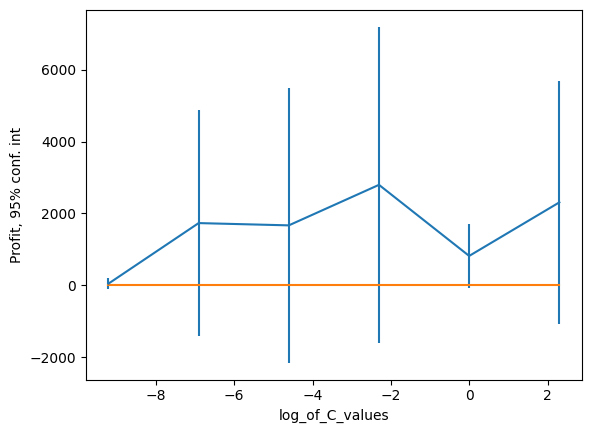

In [384]:
fig = plt.figure()

plt.errorbar(x = np.log(df_cv_results['C']),y = df_cv_results['mean_value'], yerr = [3*df_cv_results['std'], 3*df_cv_results['std']])
plt.plot(np.log(df_cv_results['C']), [0,0,0,0,0,0])

plt.xlabel("log_of_C_values")
plt.ylabel("Profit, 95%" + " conf. int")

Text(0, 0.5, 'Profit, 95% conf. int')

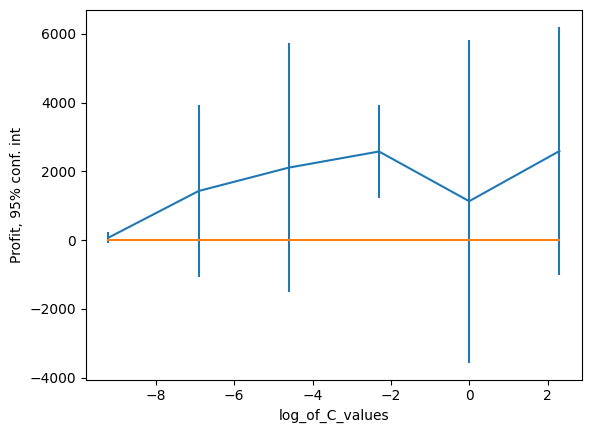

In [381]:
fig = plt.figure()

plt.errorbar(x = np.log(df_cv_results['C']),y = df_cv_results['mean_value'], yerr = [3*df_cv_results['std'], 3*df_cv_results['std']])
plt.plot(np.log(df_cv_results['C']), [0,0,0,0,0,0])

plt.xlabel("log_of_C_values")
plt.ylabel("Profit, 95%" + " conf. int")

Text(0, 0.5, 'Profit, 95% conf. int')

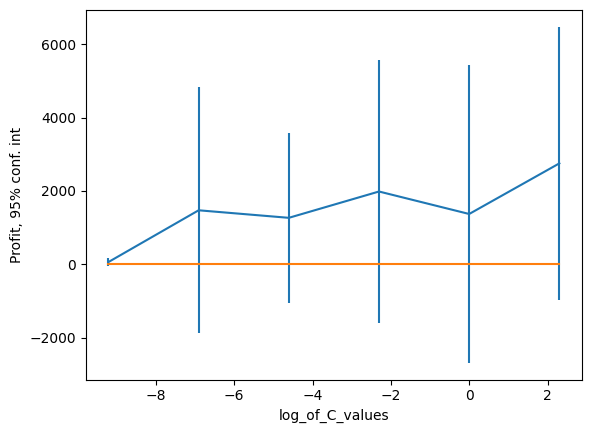

In [378]:
fig = plt.figure()

plt.errorbar(x = np.log(df_cv_results['C']),y = df_cv_results['mean_value'], yerr = [3*df_cv_results['std'], 3*df_cv_results['std']])
plt.plot(np.log(df_cv_results['C']), [0,0,0,0,0,0])

plt.xlabel("log_of_C_values")
plt.ylabel("Profit, 95%" + " conf. int")

1. Есть закономерность: значение 1е-4 всегда дает наименьшую прибыль

2. Как правило, 10 и 0.1 дают наибольшие значения, а в С = 1 всегда прибыль меньше

3. Интересно, что только в одной прогонке в доверительный интервал оценки не попал 0

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ нам важнее recall, тк нам "дороже" не позвонить тому, кто хотел бы взять депозит (в среднем -9$), чем позвонить тому, кто не хотел (-1$)



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [431]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


0.0

In [486]:
C_ = mdl.best_params_['C']

tresholds_dict = {'treshold': np.arange(0.0, 1.01, 0.01), 'recall': {'fold1': [], 'fold2': [], 'fold3': [], 'fold4': [], 'fold5': []}, \
    'precision': {'fold1': [], 'fold2': [], 'fold3': [], 'fold4': [], 'fold5': []}, \
    'profit_': {'fold1': [], 'fold2': [], 'fold3': [], 'fold4': [], 'fold5': []}  }

model  = linear_model.LogisticRegression(penalty='l2', max_iter = 1000, C = C_)
i=1

for train_index, test_index in cv.split(X, y):
    x_scaled = column_transformer_ohe.fit_transform(X)
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    pred_prob = model.predict_proba(x_test_fold)
    fold_name = 'fold' + str(i)
    
    for tr in np.arange(0.0, 1.01, 0.01):

        preds = np.array(pred_prob[:,0] > tr).astype(int)
        precision = precision_score(y_test_fold, preds)
        recall = recall_score(y_test_fold, preds)
        tresholds_dict['recall'][fold_name].append(recall)
        tresholds_dict['precision'][fold_name].append(precision)
        tresholds_dict['profit_'][fold_name].append(get_profit(y_test_fold, preds))

    i+=1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

In [487]:
df_profit = pd.DataFrame(tresholds_dict['profit_'])


df_profit['mean_profit'] = df_profit.mean(axis=1)
df_profit['std_profit'] = df_profit.iloc[:,0:5].std(axis=1)

df_profit['tr'] = np.arange(0.0, 1.01, 0.01)


In [488]:
df_recall = pd.DataFrame(tresholds_dict['recall'])

df_recall['mean_recall'] = df_recall.mean(axis=1)
df_recall['std_recall'] = df_recall.iloc[:,0:5].std(axis=1)
df_recall['tr'] = np.arange(0.0, 1.01, 0.01)


In [489]:
df_prec = pd.DataFrame(tresholds_dict['precision'])

df_prec['mean_precision'] = df_prec.mean(axis=1)
df_prec['std_prec'] = df_prec.iloc[:,0:5].std(axis=1)
df_prec['tr'] = np.arange(0.0, 1.01, 0.01)

df_prec = df_prec.drop(['fold1', 'fold2', 'fold3', 'fold4', 'fold5'], axis = 1)
df_prec['mean_recall'] = df_recall['mean_recall']
df_prec['std_recall'] = df_recall['std_recall']

In [490]:
df_prec['mean_profit'] = df_profit['mean_profit']
df_prec['std_profit'] = df_profit['std_profit']

In [491]:
df_prec

,mean_precision,std_prec,tr,mean_recall,std_recall,mean_profit,std_profit
0,0.112654,0.000007,0.00,1.000000,0.000000,-749.397557,4800.782507
1,0.112654,0.000007,0.01,1.000000,0.000000,1238.697672,5004.592758
2,0.112654,0.000007,0.02,1.000000,0.000000,-2433.164116,1220.953140
3,0.112654,0.000007,0.03,1.000000,0.000000,2723.639102,5282.654022
4,0.112654,0.000007,0.04,1.000000,0.000000,529.284505,5092.415804
...,...,...,...,...,...,...,...
96,0.034209,0.001408,0.96,0.076724,0.002891,-1710.013017,290.607420
97,0.030886,0.003899,0.97,0.025000,0.004404,-542.238414,117.374123
98,0.033010,0.009757,0.98,0.002802,0.000964,-64.275678,17.947996
99,0.000000,0.000000,0.99,0.000000,0.000000,-2.800000,1.303840


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Text(0, 0.5, 'Прибыль, $')

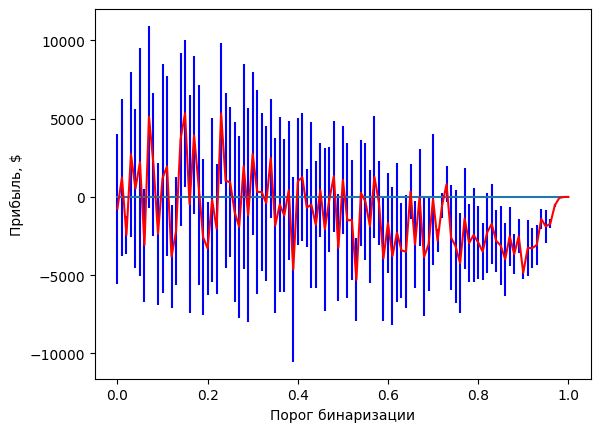

In [496]:
fig = plt.figure()

plt.errorbar( x=df_prec['tr'], y = df_prec['mean_profit'], yerr = [df_prec['std_profit'], df_prec['std_profit']], color = 'red', ecolor = 'blue')

plt.plot(df_prec['tr'], np.zeros(len(df_prec)))
plt.xlabel('Порог бинаризации')
plt.ylabel('Прибыль, $')


Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [501]:
best_treshold = df_prec.nlargest(1, 'mean_profit')
best_treshold

,mean_precision,std_prec,tr,mean_recall,std_recall,mean_profit,std_profit
15,0.111883,0.000392,0.15,0.992026,0.003855,5341.324837,4709.527707


Как было отмечено, нам важнее recall, поэтому модель, максимизируя прибыль, максимизирует и recall. Выбран (при моей реализации) бинарный порог в 15% - это логично, тк у нас дизбаланс классов в сторону нулей, поэтому вероятность того, что возьмет трубку в принципе низкая

Тенденция того, что макс прибыли при близких к 0.2 значениям порога устойчива к различным реализациям СВ

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ сходила после пары Соколовского на центральный рынок, съела роллы в каком-то корейском рестике ( не рекомендую, но выглядели красиво) и вафлю с белым шоколадом. Вот она топ топ